# Import libraries

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.deterministic import DeterministicProcess
from prophet import Prophet
from tqdm import tqdm

# Prepare Dataset

In [4]:
path = '../input/store-sales-time-series-forecasting/'

df_train = pd.read_csv(path + 'train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32'},
                       parse_dates=['date'], infer_datetime_format=True)

df_train = df_train.set_index(['store_nbr', 'family','date']).sort_index()

sdate = '2017-04-01'
edate = '2017-08-15'
df_train = df_train.unstack(['store_nbr', 'family']).loc[sdate:edate].stack(['store_nbr', 'family']).reset_index().set_index(['store_nbr', 'family'])
df_train.head()

date   sales
store_nbr family                       
1         AUTOMOTIVE 2017-04-01     9.0
          BABY CARE  2017-04-01     0.0
          BEAUTY     2017-04-01     1.0
          BEVERAGES  2017-04-01  3229.0
          BOOKS      2017-04-01     0.0

In [5]:
df_test = pd.read_csv(path + 'test.csv',
                      usecols=['id', 'store_nbr', 'family', 'date'],
                      dtype={'store_nbr': 'category', 'family': 'category'},
                      parse_dates=['date'], infer_datetime_format=True)

df_test = df_test.set_index(['store_nbr', 'family']).sort_index()

df_test.head(15)

id       date
store_nbr family                        
1         AUTOMOTIVE  3000888 2017-08-16
          AUTOMOTIVE  3002670 2017-08-17
          AUTOMOTIVE  3004452 2017-08-18
          AUTOMOTIVE  3006234 2017-08-19
          AUTOMOTIVE  3008016 2017-08-20
          AUTOMOTIVE  3009798 2017-08-21
          AUTOMOTIVE  3011580 2017-08-22
          AUTOMOTIVE  3013362 2017-08-23
          AUTOMOTIVE  3015144 2017-08-24
          AUTOMOTIVE  3016926 2017-08-25
          AUTOMOTIVE  3018708 2017-08-26
          AUTOMOTIVE  3020490 2017-08-27
          AUTOMOTIVE  3022272 2017-08-28
          AUTOMOTIVE  3024054 2017-08-29
          AUTOMOTIVE  3025836 2017-08-30

In [6]:
def get_train_dataframe(index):
    data = df_train.loc[index].reset_index().drop(columns=['store_nbr', 'family'])
    data = data.rename(columns = {"date" : "ds", "sales": "y"})
    return data

def get_index():
    for index in df_test.index.unique():
        yield index
        
def get_forecast(data):
    model = Prophet()
    model.fit(data)
    future = model.make_future_dataframe(periods=16)
    forecast = model.predict(future)
    return model, forecast

def get_predictions(forecast, index):
    data = df_test.loc[index].reset_index().drop(columns=['store_nbr', 'family'])
    merged = data.merge(forecast[['ds', 'yhat']].tail(16), left_on=['date'], right_on=['ds'])
    return merged.drop(columns=['date', 'ds'])
    

In [7]:
import warnings; warnings.simplefilter('ignore')

In [9]:
indices = tqdm(iter(get_index()), total=len(df_test.index.unique()), file=None)

concatenated = pd.DataFrame()

for index in indices:
    data = get_train_dataframe(index)
    model, forecast = get_forecast(data)
#     model.plot(forecast)
    pred = get_predictions(forecast, index)
    concatenated = pd.concat([concatenated, pred], axis=0)
    


  0%|          | 0/1782 [00:00<?, ?it/s]20:18:22 - cmdstanpy - INFO - Chain [1] start processing
20:18:22 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 2/1782 [00:01<18:54,  1.57it/s]20:18:23 - cmdstanpy - INFO - Chain [1] start processing
20:18:23 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 3/1782 [00:02<20:37,  1.44it/s]20:18:24 - cmdstanpy - INFO - Chain [1] start processing
20:18:24 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 4/1782 [00:02<19:13,  1.54it/s]20:18:25 - cmdstanpy - INFO - Chain [1] start processing
20:18:25 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 5/1782 [00:03<20:30,  1.44it/s]20:18:25 - cmdstanpy - INFO - Chain [1] start processing
20:18:25 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 6/1782 [00:04<19:44,  1.50it/s]20:18:26 - cmdstanpy - INFO - Chain [1] start processing
20:18:26 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 7/1782 [00:04<20:49,  1.4

In [10]:
concatenated

,id,yhat
0,3000888,4.124438
1,3002670,4.809972
2,3004452,6.391270
3,3006234,5.481249
4,3008016,2.327886
...,...,...
11,3022271,22.016718
12,3024053,14.694082
13,3025835,13.970793
14,3027617,12.645896


In [11]:
concatenated['yhat'] = concatenated['yhat'].apply(lambda x: 0 if x < 0 else x)
concatenated.rename(columns={'yhat': 'sales'}).to_csv('/kaggle/working/prophet.csv', index=False)

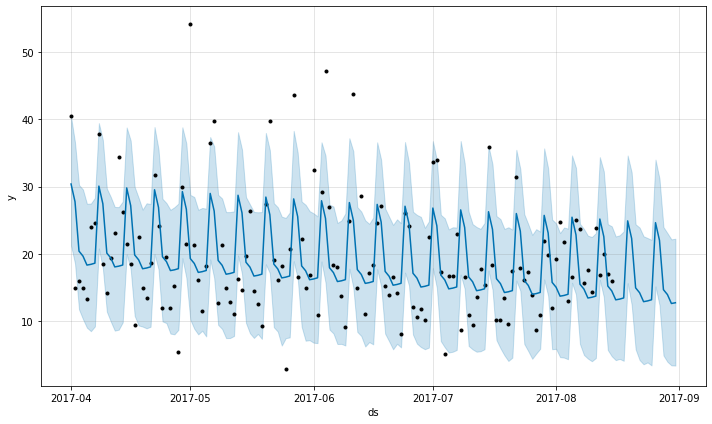

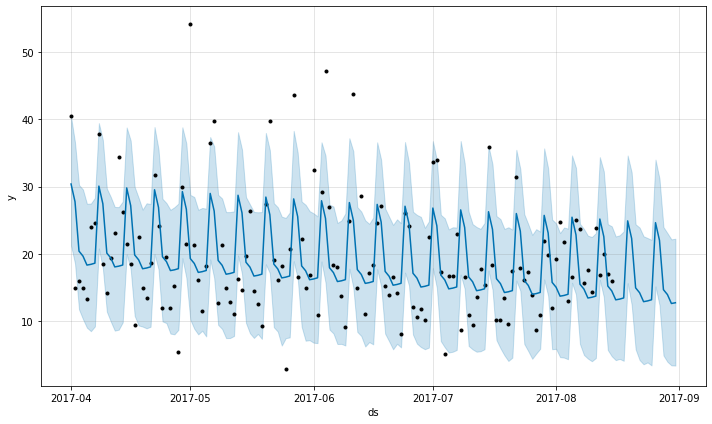

In [12]:
model.plot(forecast)